<a href="https://colab.research.google.com/github/sravyavemula12/Parking-slot-detection-using-ML/blob/main/psd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 432 images belonging to 2 classes.
Found 164 images belonging to 2 classes.
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.7875 - loss: 0.5298 - val_accuracy: 0.7683 - val_loss: 0.4804
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7863 - loss: 0.3965 - val_accuracy: 0.7866 - val_loss: 0.3613
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8730 - loss: 0.3016 - val_accuracy: 0.8841 - val_loss: 0.2833
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9450 - loss: 0.2115 - val_accuracy: 0.9024 - val_loss: 0.2362
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9686 - loss: 0.1461 - val_accuracy: 0.9146 - val_loss: 0.2064
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9721 - loss: 0.1173 - val_accuracy: 0.9146 - val_loss: 0.1979
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9799 - loss: 0.0844 - val_accuracy: 0.9146 - val_loss: 0.1960
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━

Training Accuracy: 0.9792
Validation Accuracy: 0.939



Summary:
Total Slots: 320
Occupied Slots: 146
Empty Slots: 174


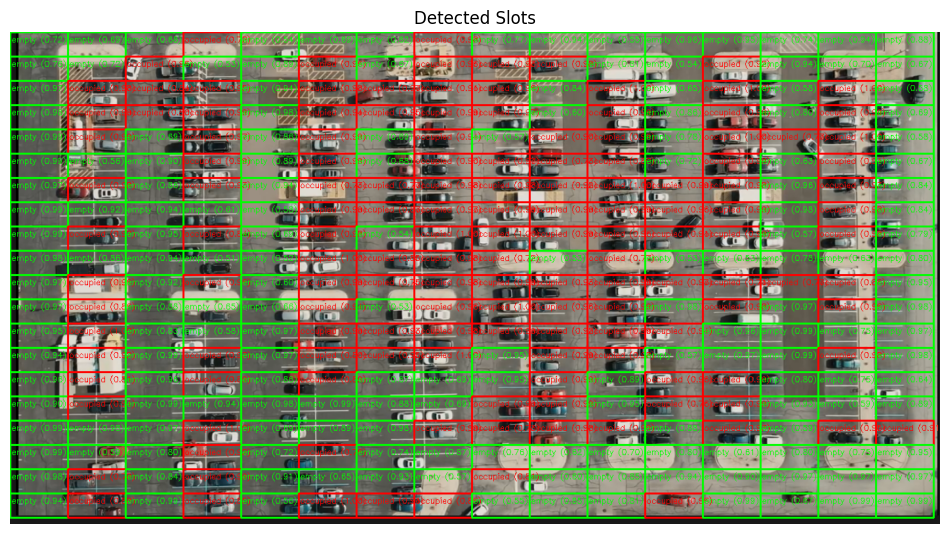

In [ ]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers

# inputs
img_width, img_height = 50, 50
batch_size = 32
epochs = 10
num_classes = 2
grid_rows, grid_cols = 20, 16 # 20x16 = 320 total slots
threshold = 0.7

zip_path = '/content/train_data.zip'
extracted_dir = '/content/parking_data'
test_image_path = '/content/P2.png'

# UNZIP FILE
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

train_dir = os.path.join(extracted_dir, 'train_data/train')
val_dir = os.path.join(extracted_dir, 'train_data/test')

# BUILD MODEL
def build_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
    for layer in base_model.layers[:10]:
        layer.trainable = False
    x = Flatten()(base_model.output)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                  metrics=['accuracy'])
    return model

# TRAIN MODEL
def train_model():
    train_gen = ImageDataGenerator(rescale=1/255., horizontal_flip=True,
                                   fill_mode='nearest', zoom_range=0.1,
                                   width_shift_range=0.1, height_shift_range=0.1, rotation_range=5)
    val_gen = ImageDataGenerator(rescale=1/255.)

    train_generator = train_gen.flow_from_directory(train_dir, target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='categorical')
    val_generator = val_gen.flow_from_directory(val_dir, target_size=(img_height, img_width),
                                                batch_size=batch_size, class_mode='categorical')

    model = build_model()
    history = model.fit(train_generator, validation_data=val_generator,
                        epochs=epochs, steps_per_epoch=len(train_generator),
                        validation_steps=len(val_generator))

    model.save('parking_status_model.h5')
    print("Training Accuracy:", round(history.history['accuracy'][-1], 4))
    print("Validation Accuracy:", round(history.history['val_accuracy'][-1], 4))

# DETECT AND CLASSIFY SLOTS
def detect_slots_and_classify(image_path):
    model = load_model('parking_status_model.h5')
    class_dictionary = {0: 'empty', 1: 'occupied'}

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError("Image not found at specified path.")

    original = image.copy()
    h, w, _ = image.shape
    slot_height = h // grid_rows
    slot_width = w // grid_cols

    occupied_count = 0
    empty_count = 0
    total_slots = grid_rows * grid_cols

    for row in range(grid_rows):
        for col in range(grid_cols):
            x1 = col * slot_width
            y1 = row * slot_height
            x2 = x1 + slot_width
            y2 = y1 + slot_height
            slot_img = image[y1:y2, x1:x2]
            slot_img_resized = cv2.resize(slot_img, (img_width, img_height))
            slot_img_resized = slot_img_resized / 255.0
            slot_img_resized = np.expand_dims(slot_img_resized, axis=0)

            prediction = model.predict(slot_img_resized, verbose=0)
            class_id = np.argmax(prediction[0])
            confidence = prediction[0][class_id]

            if class_id == 1 and confidence >= threshold:
                label = 'occupied'
                occupied_count += 1
                color = (0, 0, 255)
            else:
                label = 'empty'
                empty_count += 1
                color = (0, 255, 0)

            cv2.rectangle(original, (x1, y1), (x2, y2), color, 2)
            cv2.putText(original, f"{label} ({confidence:.2f})", (x1 + 2, y1 + 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    print("\nSummary:")
    print(f"Total Slots: {total_slots}")
    print(f"Occupied Slots: {occupied_count}")
    print(f"Empty Slots: {empty_count}")

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Detected Slots")
    plt.show()

# ====== EXECUTE TRAINING & DETECTION ======
train_model()
detect_slots_and_classify(test_image_path)
